# Taller 2
# Integrantes: 
# **Miguel Enciso**
# **Vihlai Maldonado**

## Problema
Uno de los campos de aplicación de las técnicas de deep learning es la medicina, donde se han desarrollado sistemas que ayudan a los expertos en el diagnóstico y que facilitan la detección temprana de algunas patologías. Este es el caso de algunas enfermedades del ojo, las cuales pueden ser identificadas mediante un análisis automatizado de imágenes de la retina del paciente. De esta forma, se puede apoyar la toma de decisiones oportunas para prevenir la ceguera y otras complicaciones.

En este sentido, se quiere llevar a cabo un estudio, tomando como base imágenes de retina de retinopatía diabética, de cataratas y de glaucoma, para construir un modelo que apoye en la identificación de pacientes con riesgo de sufrir estas enfermedades.

Para la construcción del modelo, es importante que realicen su propia Red Neuronal para la clasificación de estas enfermedades. En donde es importante explorar tanto sus propias redes, como Redes Pre-entrenadas. Realice una tabla comparativa entre la Red Construida y por lo menos dos Redes Pre-entrenadas con la métrica seleccionada. \
Datos: https://www.kaggle.com/datasets/gunavenkatdoddi/preprocessed-eye-diseases-fundus-images

In [1]:
!pip install keras-tuner
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 26.8 MB/s 
     |████████████████████████████████| 1.6 MB 52.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

#Tensorflow libraries
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, NASNetMobile, DenseNet169

#Keras libraries
import keras
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Reshape
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Input, Rescaling, Lambda, MaxPooling2D, Conv2D, AveragePooling2D
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model

#Scikit-learn libraries
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preparación de datos:

In [4]:
batch_size = 32
img_height = 224
img_width = 224

A continuación se realiza la división del dataset en los conjuntos de entrenamiento con el 80%, validación conel 10% y test con el 10%.

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/uniandes/adl/lab2/seg_dataset/',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 3374 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/uniandes/adl/lab2/seg_dataset/',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [14]:
val_images_list=[]
val_labels_list=[]
test_images_list=[]
test_labels_list=[]
i=0
for images_val, labels_val in val_ds.unbatch():
  # Tomamos la mitad para el conjunto de validación y a otra mitad para el de test.
  if i>421:
    test_images_list.append(images_val)
    test_labels_list.append(labels_val)
  else:
    val_images_list.append(images_val)
    val_labels_list.append(labels_val)
  i+=1
val_ds =validation_data=tf.data.Dataset.from_tensor_slices((val_images_list, val_labels_list)).batch(batch_size)
test_ds =validation_data=tf.data.Dataset.from_tensor_slices((test_images_list, test_labels_list)).batch(batch_size)

### Exploración de datos

In [15]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


De lo anterior podemos evidenciar que tenemos 4 clases, una normal y 3 con problemas.

A continuación se grafican algunas de las imágenes junto con su etiqueta en los conjuntos de entrenamiento y validación.

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


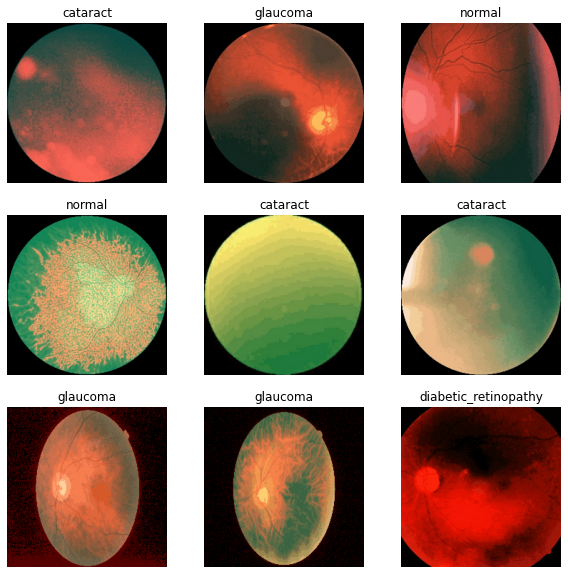

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


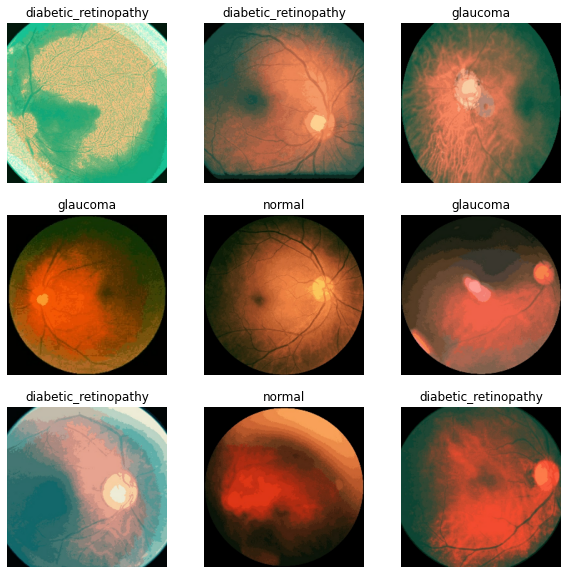

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        print(images[i].numpy().shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

A continuación se evalua la presencia de valores negativos en el dataset y valores por encima de 255 en las columnas de pixeles.

In [18]:
def check_outside_range_values_images(dataset):
  for images, labels in dataset.unbatch():
    if np.any(images<0):
      print('El dataset tiene valores negativos')
    if np.any(images>255):
      print('EL dataset tiene valores por encima de 255')
check_outside_range_values_images(train_ds)
check_outside_range_values_images(val_ds)

De lo anterior concluimos que no tenemos valores fuera del rango en el dataset.

Para revisar los duplicados, se calculará como primer paso la suma del numpy array de cada imágen y se comparará con las demás si tienen el mismo valor. En caso de tener el mismo valor, dado que una imágen podría tener la misma suma pero en diferente orden se realizará la compración de tal numpy array elemento a elemento.

In [ ]:
def check_duplicates_by_sum_images(dataset):
  sum_list=[]
  for images, labels in dataset.unbatch():
    sum_list+=np.sum(images)
  if len(sum_list) == len(set(sum_list)):
    print("No hay duplicados")
  else:
    print("Hay duplicados")
check_duplicates_by_sum_images(train_ds)
check_duplicates_by_sum_images(val_ds)
check_duplicates_by_sum_images(test_ds)

No hay duplicados
No hay duplicados
No hay duplicados


Del resultado anterior concluimos que no hay duplicados.

Distribución de las clases en el conjunto de entrenamiento:

In [19]:
images=list(train_ds.unbatch().map(lambda x, y: x))
labels=list(train_ds.unbatch().map(lambda x, y: y))
len(images)

3374

In [ ]:
clases_counts=[0, 0, 0, 0]
for instance in labels:
  if np.all(instance==np.array([1, 0, 0, 0])):
    clases_counts[0]+=1
  if np.all(instance==np.array([0, 1, 0, 0])):
    clases_counts[1]+=1
  if np.all(instance==np.array([0, 0, 1, 0])):
    clases_counts[2]+=1
  if np.all(instance==np.array([0, 0, 0, 1])):
    clases_counts[3]+=1
clases_counts

[836, 884, 802, 852]

Observamos que en el conjunto de entrenamiento tenemos una cantidad relativamente balanceada de clases.

### Utils functions

In [20]:
def plot_metrics_training_validation(history):
  plt.plot(history.history['recall'], label='Training recall')
  plt.plot(history.history['val_recall'], label='Test recall')
  plt.plot(history.history['precision'], label='Training precision')
  plt.plot(history.history['val_precision'], label='Test precision')
  plt.title('Training and validation metrics')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [21]:
def predict_data(clf_model, dataset):
  y_true = list()
  y_pred = list()

  for images, labels in dataset:
      pred = clf_model.predict(images)
      for i in range(len(pred)):
          y_true.append(labels[i].numpy())
          y_pred.append((pred[i] == pred[i].max()).astype(int))
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return y_true, y_pred

In [22]:
def plot_figures_labels(clf_model, dataset):
  plt.figure(figsize=(10, 10))

  df = dataset.take(1)

  for images, labels in df:
      pred = clf_model.predict(images)
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(class_names[pred[i].argmax()])
          plt.axis("off")

## Modelamiento


Al estar en un contexto médico donde la predicción erronea a pacientes con enfermedad es costosa, se le dará prioridad al recall, es decir se espera reducir los Falsos Negativos del clasificador.

### Red no-preentrenada

In [23]:
model1 = keras.models.Sequential([
    keras.layers.Conv2D(filters = 64, kernel_size=(8,8), activation='relu', input_shape=[img_height, img_width, 3]),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters = 128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters = 128, kernel_size=(3,3), activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters = 256, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters = 256, kernel_size=(3,3), activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters = 512, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters = 512, kernel_size=(3,3), activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax')
])
clf1 = Sequential(name='Red_con_Conocimiento')

clf1.add(model1)
# clf1.add(GlobalAveragePooling2D(name='Pooling'))
clf1.add(Dense(50, activation="relu", name='Dense_1'))
clf1.add(Dense(10, activation="relu", name='Dense_2'))
clf1.add(Dense(len(class_names), activation="softmax", name='Dense_out'))

clf1.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf1.summary()
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max')
]


Model: "Red_con_Conocimiento"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                17783562  
                                                                 
 Dense_1 (Dense)             (None, 50)                550       
                                                                 
 Dense_2 (Dense)             (None, 10)                510       
                                                                 
 Dense_out (Dense)           (None, 4)                 44        
                                                                 
Total params: 17,784,666
Trainable params: 17,784,666
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = clf1.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks)


Epoch 1/50
106/106 [==============================] - 44s 282ms/step - loss: 1.3884 - acc: 0.2519 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3861 - val_acc: 0.2773 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
106/106 [==============================] - 28s 245ms/step - loss: 1.3863 - acc: 0.2596 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3872 - val_acc: 0.2299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
106/106 [==============================] - 28s 246ms/step - loss: 1.3865 - acc: 0.2599 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3873 - val_acc: 0.2299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
106/106 [==============================] - 28s 249ms/step - loss: 1.3868 - acc: 0.2596 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3872 - val_acc: 0.2299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


Variación de hiperparámetros

In [25]:
def build_model(hp):
    inputs = keras.Input(shape=(img_height, img_width, 3))
    # Model type can be MLP or CNN.
    model_type = hp.Choice("model_type", ["cnn"])
    x = inputs
        # Number of layers of the CNN is also a hyperparameter.
    for i in range(hp.Int("cnn_layers", 1, 3)):
        x = keras.layers.Conv2D(
            hp.Int(f"filters_{i}", 32, 128, step=32),
            kernel_size=(3, 3),
            activation="relu",
        )(x)
        x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)

    # A hyperparamter for whether to use dropout layer.
    if hp.Boolean("dropout"):
        x = keras.layers.Dropout(0.5)(x)

    # The last layer contains 10 units,
    # which is the same as the number of classes.
    # x= keras.layers.Dense(50, activation="relu", name='Dense_1')
    # x = keras.layers.Dense(10, activation="relu", name='Dense_2')

    outputs = keras.layers.Dense(units=4, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model.
    model.compile(
        loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam",
    )
    return model

In [26]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     hyperband_iterations=10,
                     directory='kt_dir',
                     project_name='ket_hyperband')

In [ ]:
tuner.search(train_ds, validation_data = val_ds, callbacks=my_callbacks)

Trial 18 Complete [00h 07m 23s]
val_accuracy: 0.7615658640861511

Best val_accuracy So Far: 0.8256227970123291
Total elapsed time: 00h 07m 23s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
cnn               |cnn               |model_type
1                 |2                 |mlp_layers
96                |64                |units_0
False             |True              |dropout
96                |96                |units_1
2                 |3                 |cnn_layers
64                |128               |filters_0
96                |64                |filters_1
64                |128               |filters_2
7                 |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/7
 28/106 [======>.......................] - ETA: 12s - loss: 98.6550 - accuracy: 0.4989 

### Datos de entrenamiento

In [ ]:
y_true_train_nasnet, y_pred_train_nasnet = predict_data(clf_proposed, train_ds)

print(classification_report(y_true_train_nasnet, y_pred_train_nasnet, target_names=list(class_names)))

NameError: ignored

### Datos de validación

                      precision    recall  f1-score   support

            cataract       0.00      0.00      0.00       202
diabetic_retinopathy       0.25      1.00      0.40       214
            glaucoma       0.00      0.00      0.00       205
              normal       0.00      0.00      0.00       222

           micro avg       0.25      0.25      0.25       843
           macro avg       0.06      0.25      0.10       843
        weighted avg       0.06      0.25      0.10       843
         samples avg       0.25      0.25      0.25       843



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Datos de test

## Redes preentrenadas

A continuación se usará un par de redes pre-entrenadas con el fin de comparar el comportamiento de estas redes con la propuesta.\
Como primera opción se usará `InceptionV3`. Esta es una red que se usó en clase y que probaremos su desempeño para clasificación de enfermedades oculares. Asimismo, de acuerdo con [keras](https://keras.io/api/applications/inceptionv3/), es una red que cuenta con 23.9M	de parámetros, una profundidad de 189 y un desempeño de 93.7% en Top5-accuracy. Es una red medianamente grande comparada con las redes disponibles en Keras.

## Inception V3

In [ ]:
inceptionv3_model = InceptionV3(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

inceptionv3_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
clf_inception = Sequential(name='Red_con_Conocimiento')

clf_inception.add(inceptionv3_model)
clf_inception.add(GlobalAveragePooling2D(name='Pooling'))
clf_inception.add(Dense(50, activation="relu", name='Dense_1'))
clf_inception.add(Dense(10, activation="relu", name='Dense_2'))
clf_inception.add(Dense(len(class_names), activation="softmax", name='Dense_out'))

clf_inception.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf_inception.summary()

Model: "Red_con_Conocimiento"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 Pooling (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Dense_1 (Dense)             (None, 50)                102450    
                                                                 
 Dense_2 (Dense)             (None, 10)                510       
                                                                 
 Dense_out (Dense)           (None, 4)                 44        
                                                                 
Total params: 21,905,788
Trainable params: 21,871,356
Non-trainable params: 34,432
_____________________________

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max')
]

In [ ]:
history = clf_inception.fit(train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=my_callbacks
    )

Epoch 1/10
106/106 [==============================] - 39s 282ms/step - loss: 0.4495 - acc: 0.8432 - precision: 0.8764 - recall: 0.8094 - val_loss: 12.8082 - val_acc: 0.4526 - val_precision: 0.4530 - val_recall: 0.4455
Epoch 2/10
106/106 [==============================] - 29s 264ms/step - loss: 0.3250 - acc: 0.8823 - precision: 0.8944 - recall: 0.8684 - val_loss: 1.3903 - val_acc: 0.6872 - val_precision: 0.6888 - val_recall: 0.6872
Epoch 3/10
106/106 [==============================] - 29s 259ms/step - loss: 0.2132 - acc: 0.9262 - precision: 0.9298 - recall: 0.9226 - val_loss: 0.4390 - val_acc: 0.8626 - val_precision: 0.8612 - val_recall: 0.8531
Epoch 4/10
106/106 [==============================] - 29s 262ms/step - loss: 0.2092 - acc: 0.9212 - precision: 0.9275 - recall: 0.9182 - val_loss: 1.6288 - val_acc: 0.6659 - val_precision: 0.6667 - val_recall: 0.6588
Epoch 5/10
106/106 [==============================] - 29s 263ms/step - loss: 0.1795 - acc: 0.9360 - precision: 0.9399 - recall: 0.9

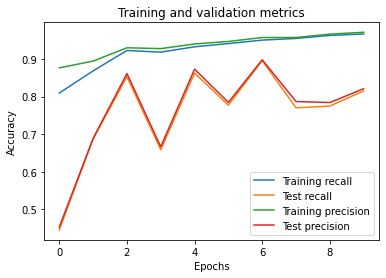

In [ ]:
plot_metrics_training_validation(history)

### Datos de entrenamiento

In [ ]:
y_true_train_nasnet, y_pred_train_nasnet = predict_data(clf_inception, train_ds)

print(classification_report(y_true_train_nasnet, y_pred_train_nasnet, target_names=list(class_names)))

1/1 [==============================] - 1s 1s/step
                      precision    recall  f1-score   support

            cataract       0.98      0.92      0.95       836
diabetic_retinopathy       1.00      0.97      0.99       884
            glaucoma       0.75      0.99      0.85       802
              normal       0.98      0.77      0.86       852

           micro avg       0.91      0.91      0.91      3374
           macro avg       0.93      0.91      0.91      3374
        weighted avg       0.93      0.91      0.91      3374
         samples avg       0.91      0.91      0.91      3374



De acuerdo con el resultado anterior observamos un buen desempeño en el recall de las clases cataract, diabetic_retinopathy y glaucoma en el conjunto de entrenamiento. En cambio tenemos un desempeño de 0.77 en el recall en la clase normal.

1/1 [==============================] - 0s 38ms/step


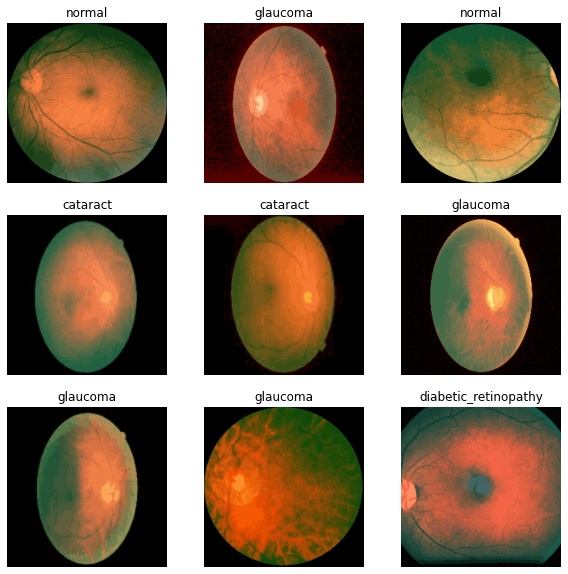

In [ ]:
plot_figures_labels(clf_inception, train_ds)

### Datos de validación

In [ ]:
y_true_val_nasnet, y_pred_val_nasnet = predict_data(clf_inception, val_ds)

print(classification_report(y_true_val_nasnet, y_pred_val_nasnet, target_names=list(class_names)))

1/1 [==============================] - 0s 27ms/step
                      precision    recall  f1-score   support

            cataract       0.94      0.77      0.84        98
diabetic_retinopathy       1.00      0.94      0.97        95
            glaucoma       0.60      0.94      0.73       107
              normal       0.94      0.65      0.77       122

           micro avg       0.82      0.82      0.82       422
           macro avg       0.87      0.82      0.83       422
        weighted avg       0.87      0.82      0.82       422
         samples avg       0.82      0.82      0.82       422



De acuerdo con el resultado anterior observamos un buen desempeño en el recall para las clases diabetic_retinopathy y glaucoma con 0.94. Obtuvo un desempeño de 0.77 en recall para la clase catarct y la clase normal obtuvo sólo 0.65. La clase que tuvo menor desempeño en el recall normal con 0.95. 

### Datos de test

In [ ]:
y_true_test_nasnet, y_pred_test_nasnet = predict_data(clf_inception, test_ds)

print(classification_report(y_true_test_nasnet, y_pred_test_nasnet, target_names=list(class_names)))


1/1 [==============================] - 1s 770ms/step
                      precision    recall  f1-score   support

            cataract       0.96      0.88      0.91       104
diabetic_retinopathy       1.00      0.92      0.96       119
            glaucoma       0.65      0.95      0.77        98
              normal       0.96      0.70      0.81       100

           micro avg       0.86      0.86      0.86       421
           macro avg       0.89      0.86      0.86       421
        weighted avg       0.90      0.86      0.87       421
         samples avg       0.86      0.86      0.86       421



De acuerdo con el resultado anterior observamos un buen desempeño en el recall para las clases diabetic_retinopathy y glaucoma con 0.92 y 9.95 respectivamente. Obtuvo un desempeño de 0.88 en recall para la clase catarct y la clase normal obtuvo 0.70. La clase que tuvo menor desempeño en el recall sigue siendo normal con 0.70.

1/1 [==============================] - 0s 38ms/step


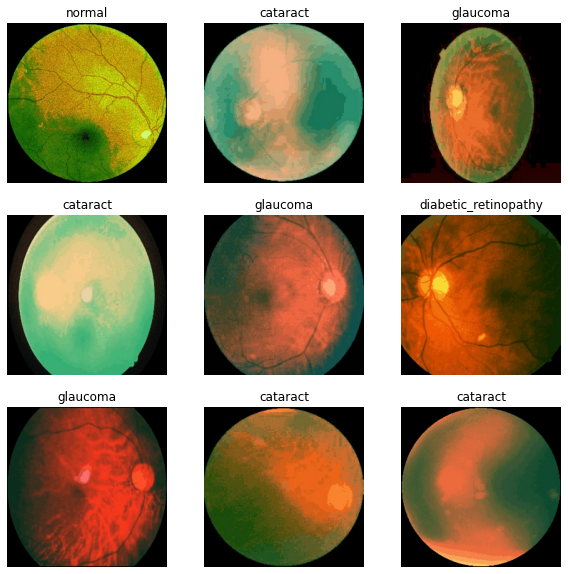

In [ ]:
plot_figures_labels(clf_inception, test_ds)

## NasNetMobile

Como segunda opción usaremos la red `NasNetMobile`, de acuerdo con [keras](https://keras.io/api/applications/nasnet/#nasnetmobile-function) posee 5.3M de parámetros, una profundidad de 389 y presenta un desempeño de 91.9%	en Top5-accuracy. Es una red más pequeña que Inception, tiene menos parámetros, cuenta con menor tiempo de ejecución y la usaremos para comparar el resultado de una red preentrenada de menor complejidad versus la arquitectura de InceptionV3.

In [ ]:
nasnet_model = DenseNet169(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet",
)

nasnet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                       

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max')
]

clf_nasnet = Sequential(name='Red_con_Nasnet')

clf_nasnet.add(nasnet_model)
clf_nasnet.add(GlobalAveragePooling2D(name='Pooling'))
clf_nasnet.add(Dense(500, activation="relu", name='Dense_1'))
clf_nasnet.add(Dense(500, activation="relu", name='Dense_2'))
clf_nasnet.add(Dense(500, activation="relu", name='Dense_3'))
clf_nasnet.add(Dense(100, activation="relu", name='Dense_4'))
clf_nasnet.add(Dense(len(class_names), activation="softmax", name='Dense_out'))

clf_nasnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc",tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

clf_nasnet.summary()

Model: "Red_con_Nasnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 Pooling (GlobalAveragePooli  (None, 1664)             0         
 ng2D)                                                           
                                                                 
 Dense_1 (Dense)             (None, 500)               832500    
                                                                 
 Dense_2 (Dense)             (None, 500)               250500    
                                                                 
 Dense_3 (Dense)             (None, 500)               250500    
                                                                 
 Dense_4 (Dense)             (None, 100)               50100     
                                                    

In [ ]:
history = clf_nasnet.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
106/106 [==============================] - 70s 496ms/step - loss: 0.3011 - acc: 0.9052 - precision: 0.9233 - recall: 0.8850 - val_loss: 0.4980 - val_acc: 0.8578 - val_precision: 0.8578 - val_recall: 0.8578
Epoch 2/50
106/106 [==============================] - 49s 451ms/step - loss: 0.2182 - acc: 0.9223 - precision: 0.9300 - recall: 0.9173 - val_loss: 0.6328 - val_acc: 0.8294 - val_precision: 0.8301 - val_recall: 0.8223
Epoch 3/50
106/106 [==============================] - 49s 452ms/step - loss: 0.2289 - acc: 0.9182 - precision: 0.9264 - recall: 0.9096 - val_loss: 0.5897 - val_acc: 0.8341 - val_precision: 0.8540 - val_recall: 0.8175
Epoch 4/50
106/106 [==============================] - 49s 451ms/step - loss: 0.1911 - acc: 0.9360 - precision: 0.9409 - recall: 0.9292 - val_loss: 1.4547 - val_acc: 0.7370 - val_precision: 0.7458 - val_recall: 0.7370


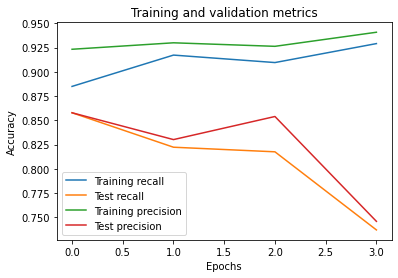

In [ ]:
plot_metrics_training_validation(history)

### Datos de entrenamiento

In [ ]:
y_true_train_nasnet, y_pred_train_nasnet = predict_data(clf_nasnet, train_ds)

print(classification_report(y_true_train_nasnet, y_pred_train_nasnet, target_names=list(class_names)))

1/1 [==============================] - 2s 2s/step
                      precision    recall  f1-score   support

            cataract       0.77      0.98      0.86       836
diabetic_retinopathy       1.00      0.99      0.99       884
            glaucoma       0.62      0.96      0.76       802
              normal       1.00      0.23      0.37       852

           micro avg       0.79      0.79      0.79      3374
           macro avg       0.85      0.79      0.75      3374
        weighted avg       0.85      0.79      0.75      3374
         samples avg       0.79      0.79      0.79      3374



De acuerdo al resultado anterior, observamos un buen desepeño en el recall de clas clases cataract, diabetic_retinopathy y glaucoma. En cambio en la clase normal obtuvimos 0.23, de manera similar a la red InceptionV3 esta clase es la de menor desempeño en el recall.

1/1 [==============================] - 0s 49ms/step


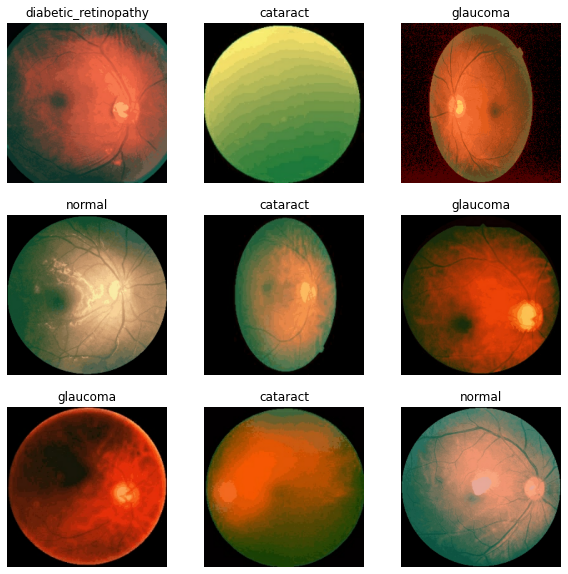

In [ ]:
plot_figures_labels(clf_nasnet, train_ds)

### Datos de validación

In [ ]:
y_true_val_nasnet, y_pred_val_nasnet = predict_data(clf_nasnet, val_ds)

print(classification_report(y_true_val_nasnet, y_pred_val_nasnet, target_names=list(class_names)))

1/1 [==============================] - 0s 38ms/step
                      precision    recall  f1-score   support

            cataract       0.75      0.96      0.84        98
diabetic_retinopathy       1.00      1.00      1.00        95
            glaucoma       0.55      0.93      0.69       107
              normal       1.00      0.19      0.32       122

           micro avg       0.74      0.74      0.74       422
           macro avg       0.83      0.77      0.71       422
        weighted avg       0.83      0.74      0.69       422
         samples avg       0.74      0.74      0.74       422



De acuerdo al resultado anterior, observamos un buen desepeño en el recall de clas clases cataract, diabetic_retinopathy y glaucoma, esta última con 0.93. En cambio en la clase normal obtuvimos 0.19, inferior que el obtenido en el conjunto de entrenamiento.

1/1 [==============================] - 0s 44ms/step


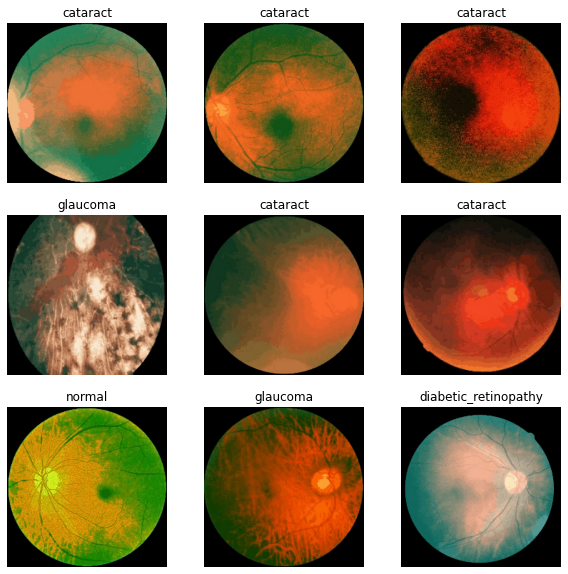

In [ ]:
plot_figures_labels(clf_nasnet, val_ds)

### Datos de test

In [ ]:
y_true_test_nasnet, y_pred_test_nasnet = predict_data(clf_nasnet, test_ds)

print(classification_report(y_true_test_nasnet, y_pred_test_nasnet, target_names=list(class_names)))

1/1 [==============================] - 0s 34ms/step
                      precision    recall  f1-score   support

            cataract       0.79      0.94      0.86       104
diabetic_retinopathy       0.99      0.98      0.99       119
            glaucoma       0.59      0.91      0.71        98
              normal       1.00      0.27      0.43       100

           micro avg       0.79      0.79      0.79       421
           macro avg       0.84      0.78      0.75       421
        weighted avg       0.85      0.79      0.76       421
         samples avg       0.79      0.79      0.79       421



De acuerdo al resultado anterior, observamos un buen desepeño en el recall de clas clases cataract, diabetic_retinopathy y glaucoma, esta última con 0.91. En cambio en la clase normal obtuvimos 0.27.

1/1 [==============================] - 0s 44ms/step


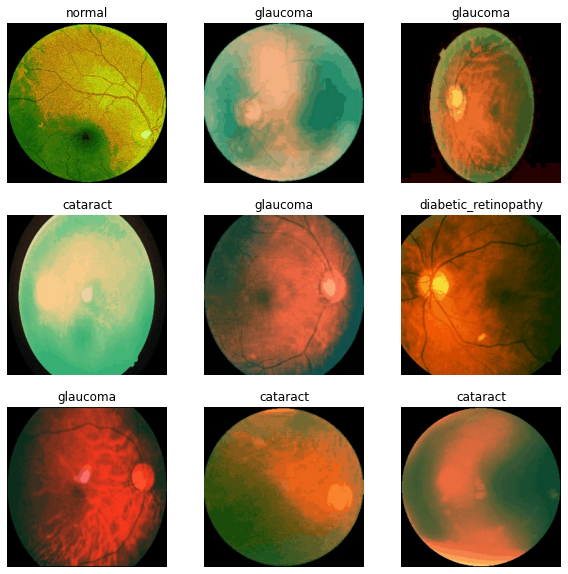

In [ ]:
plot_figures_labels(clf_nasnet, test_ds)

In [33]:
model = Sequential(name="rnc")

In [34]:
model.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Capa_Entrada'))
model.add(Rescaling(1./255,name='Capa_Reescalado'))

model.summary()

Model: "rnc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 224, 224, 3)      0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.add(Conv2D(128, (3, 3), activation='relu', name='Capa_Convolucional_1'))
model.add(MaxPooling2D((2, 2), name='Max_Pool_1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='Capa_Convolucional_2'))
model.add(AveragePooling2D((2, 2), name='Avg_Pool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_3'))
model.summary()

Model: "rnc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 224, 224, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 222, 222, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 111, 111, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 109, 109, 32)     36896     
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 54, 54, 32)       0         
 D)                                                              
                                                               

In [36]:
model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(100,activation='relu',name='Capa_Densa_1'))
model.add(Dense(50,activation='relu',name='Capa_Densa_2'))
model.summary()

Model: "rnc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 224, 224, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 222, 222, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 111, 111, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 109, 109, 32)     36896     
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 54, 54, 32)       0         
 D)                                                              
                                                               

In [37]:
model.add(Dense(len(class_names),activation='softmax',name='Capa_Respuesta'))
model.summary()

Model: "rnc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 224, 224, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 222, 222, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 111, 111, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 109, 109, 32)     36896     
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 54, 54, 32)       0         
 D)                                                              
                                                               

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "rnc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 224, 224, 3)      0         
                                                                 
 Capa_Convolucional_1 (Conv2  (None, 222, 222, 128)    3584      
 D)                                                              
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 111, 111, 128)     0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 109, 109, 32)     36896     
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 54, 54, 32)       0         
 D)                                                              
                                                               

In [39]:
history = model.fit(train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=my_callbacks
    )

Epoch 1/50
106/106 [==============================] - 24s 195ms/step - loss: 1.2666 - precision: 0.6863 - recall: 0.0759 - val_loss: 1.1747 - val_precision: 0.6138 - val_recall: 0.2749
Epoch 2/50
106/106 [==============================] - 22s 193ms/step - loss: 1.0227 - precision: 0.7126 - recall: 0.2866 - val_loss: 1.0585 - val_precision: 0.5699 - val_recall: 0.3863
Epoch 3/50
106/106 [==============================] - 21s 186ms/step - loss: 0.9045 - precision: 0.7453 - recall: 0.3980 - val_loss: 0.9877 - val_precision: 0.6589 - val_recall: 0.4028
Epoch 4/50
106/106 [==============================] - 21s 188ms/step - loss: 0.8106 - precision: 0.7406 - recall: 0.4798 - val_loss: 0.8763 - val_precision: 0.7018 - val_recall: 0.4573
Epoch 5/50
106/106 [==============================] - 22s 189ms/step - loss: 0.7668 - precision: 0.7569 - recall: 0.5139 - val_loss: 0.7753 - val_precision: 0.7329 - val_recall: 0.5332
Epoch 6/50
106/106 [==============================] - 21s 185ms/step - loss

0.6773314476013184

In [49]:
funciones = ['relu', 'softmax']
densas = [10,25,50]

In [52]:
rows = []
for x in funciones:
  for y in densas:
    model = Sequential(name="rnc")
    model.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Capa_Entrada'))
    model.add(Rescaling(1./255,name='Capa_Reescalado'))
    model.add(Conv2D(32, (3, 3), activation='relu', name='Capa_Convolucional_2'))
    model.add(AveragePooling2D((2, 2), name='Avg_Pool_1'))
    model.add(Conv2D(64, (3, 3), activation=x, name='Capa_Convolucional_3'))
    model.add(Flatten(name='Flatten_Layer'))
    model.add(Dense(y,activation=x,name='Capa_Densa_1'))
    model.add(Dense(y,activation=x,name='Capa_Densa_2'))  
    model.add(Dense(len(class_names),activation='softmax',name='Capa_Respuesta'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history = model.fit(train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=my_callbacks
    )
    rows.append([x, y, min(history.history['val_loss'])])


Epoch 1/10
105/106 [============================>.] - ETA: 0s - loss: 1.3291 - precision_3: 0.7400 - recall_3: 0.0551

106/106 [==============================] - 23s 177ms/step - loss: 1.3290 - precision_3: 0.7410 - recall_3: 0.0551 - val_loss: 1.2459 - val_precision_3: 0.9259 - val_recall_3: 0.1185
Epoch 2/10
105/106 [============================>.] - ETA: 0s - loss: 1.2120 - precision_3: 0.8513 - recall_3: 0.1551

106/106 [==============================] - 19s 166ms/step - loss: 1.2125 - precision_3: 0.8504 - recall_3: 0.1550 - val_loss: 1.2739 - val_precision_3: 1.0000 - val_recall_3: 0.0592
Epoch 3/10
106/106 [==============================] - ETA: 0s - loss: 1.2959 - precision_3: 0.7473 - recall_3: 0.0622

106/106 [==============================] - 20s 176ms/step - loss: 1.2959 - precision_3: 0.7473 - recall_3: 0.0622 - val_loss: 1.2577 - val_precision_3: 0.9444 - val_recall_3: 0.0806
Epoch 4/10
105/106 [============================>.] - ETA: 0s - loss: 1.2355 - precision_3: 0.9395 - recall_3: 0.1247

106/106 [==============================] - 19s 165ms/step - loss: 1.2351 - precision_3: 0.9397 - recall_3: 0.1248 - val_loss: 1.1802 - val_precision_3: 0.9841 - val_recall_3: 0.1469
Epoch 5/10
105/106 [============================>.] - ETA: 0s - loss: 1.2228 - precision_3: 0.8740 - recall_3: 0.1280

106/106 [==============================] - 19s 166ms/step - loss: 1.2226 - precision_3: 0.8745 - recall_3: 0.1280 - val_loss: 1.1681 - val_precision_3: 1.0000 - val_recall_3: 0.1493
Epoch 6/10
105/106 [============================>.] - ETA: 0s - loss: 1.1156 - precision_3: 0.9513 - recall_3: 0.1920

106/106 [==============================] - 19s 165ms/step - loss: 1.1150 - precision_3: 0.9516 - recall_3: 0.1924 - val_loss: 1.0631 - val_precision_3: 0.9674 - val_recall_3: 0.2109
Epoch 7/10
105/106 [============================>.] - ETA: 0s - loss: 1.1071 - precision_3: 0.9169 - recall_3: 0.2003

106/106 [==============================] - 20s 174ms/step - loss: 1.1082 - precision_3: 0.9169 - recall_3: 0.1995 - val_loss: 1.2997 - val_precision_3: 1.0000 - val_recall_3: 0.0545
Epoch 8/10
105/106 [============================>.] - ETA: 0s - loss: 1.0773 - precision_3: 0.9254 - recall_3: 0.2068

106/106 [==============================] - 19s 166ms/step - loss: 1.0772 - precision_3: 0.9257 - recall_3: 0.2069 - val_loss: 1.0795 - val_precision_3: 0.8482 - val_recall_3: 0.2251
Epoch 9/10
105/106 [============================>.] - ETA: 0s - loss: 1.0173 - precision_3: 0.9433 - recall_3: 0.2378

106/106 [==============================] - 19s 164ms/step - loss: 1.0172 - precision_3: 0.9435 - recall_3: 0.2377 - val_loss: 1.0219 - val_precision_3: 0.9890 - val_recall_3: 0.2133
Epoch 10/10
105/106 [============================>.] - ETA: 0s - loss: 1.0328 - precision_3: 0.9409 - recall_3: 0.2226

106/106 [==============================] - 19s 165ms/step - loss: 1.0339 - precision_3: 0.9400 - recall_3: 0.2229 - val_loss: 1.1579 - val_precision_3: 0.9815 - val_recall_3: 0.1256
Epoch 1/10
105/106 [============================>.] - ETA: 0s - loss: 1.2684 - precision_4: 0.7367 - recall_4: 0.0741

106/106 [==============================] - 20s 167ms/step - loss: 1.2709 - precision_4: 0.7331 - recall_4: 0.0741 - val_loss: 1.6837 - val_precision_4: 0.2922 - val_recall_4: 0.2299
Epoch 2/10
105/106 [============================>.] - ETA: 0s - loss: 1.0468 - precision_4: 0.7224 - recall_4: 0.2417

106/106 [==============================] - 19s 164ms/step - loss: 1.0455 - precision_4: 0.7236 - recall_4: 0.2421 - val_loss: 0.9112 - val_precision_4: 0.6732 - val_recall_4: 0.4100
Epoch 3/10
105/106 [============================>.] - ETA: 0s - loss: 0.9060 - precision_4: 0.7407 - recall_4: 0.3801

106/106 [==============================] - 20s 175ms/step - loss: 0.9070 - precision_4: 0.7403 - recall_4: 0.3794 - val_loss: 0.8973 - val_precision_4: 0.7766 - val_recall_4: 0.3460
Epoch 4/10
105/106 [============================>.] - ETA: 0s - loss: 0.8408 - precision_4: 0.7393 - recall_4: 0.4405

106/106 [==============================] - 19s 166ms/step - loss: 0.8406 - precision_4: 0.7396 - recall_4: 0.4410 - val_loss: 0.9491 - val_precision_4: 0.6513 - val_recall_4: 0.4028
Epoch 5/10
105/106 [============================>.] - ETA: 0s - loss: 0.8028 - precision_4: 0.7307 - recall_4: 0.4723

106/106 [==============================] - 19s 164ms/step - loss: 0.8018 - precision_4: 0.7310 - recall_4: 0.4727 - val_loss: 0.8885 - val_precision_4: 0.6622 - val_recall_4: 0.4692
Epoch 6/10
105/106 [============================>.] - ETA: 0s - loss: 0.7671 - precision_4: 0.7502 - recall_4: 0.5104

106/106 [==============================] - 19s 163ms/step - loss: 0.7679 - precision_4: 0.7497 - recall_4: 0.5095 - val_loss: 0.9415 - val_precision_4: 0.6716 - val_recall_4: 0.4265
Epoch 7/10
105/106 [============================>.] - ETA: 0s - loss: 0.7445 - precision_4: 0.7485 - recall_4: 0.5253

106/106 [==============================] - 19s 164ms/step - loss: 0.7436 - precision_4: 0.7486 - recall_4: 0.5261 - val_loss: 0.8390 - val_precision_4: 0.6982 - val_recall_4: 0.5427
Epoch 8/10
105/106 [============================>.] - ETA: 0s - loss: 0.7212 - precision_4: 0.7546 - recall_4: 0.5464

106/106 [==============================] - 19s 165ms/step - loss: 0.7219 - precision_4: 0.7543 - recall_4: 0.5459 - val_loss: 0.7576 - val_precision_4: 0.7231 - val_recall_4: 0.5569
Epoch 9/10
105/106 [============================>.] - ETA: 0s - loss: 0.6997 - precision_4: 0.7688 - recall_4: 0.5571

106/106 [==============================] - 19s 165ms/step - loss: 0.6996 - precision_4: 0.7687 - recall_4: 0.5575 - val_loss: 0.8087 - val_precision_4: 0.6891 - val_recall_4: 0.5569
Epoch 10/10
105/106 [============================>.] - ETA: 0s - loss: 0.6733 - precision_4: 0.7664 - recall_4: 0.5810

106/106 [==============================] - 19s 163ms/step - loss: 0.6734 - precision_4: 0.7661 - recall_4: 0.5815 - val_loss: 0.7615 - val_precision_4: 0.7166 - val_recall_4: 0.5332
Epoch 1/10
105/106 [============================>.] - ETA: 0s - loss: 1.2106 - precision_5: 0.7621 - recall_5: 0.1125

106/106 [==============================] - 20s 167ms/step - loss: 1.2117 - precision_5: 0.7595 - recall_5: 0.1123 - val_loss: 1.1655 - val_precision_5: 0.4405 - val_recall_5: 0.3246
Epoch 2/10
105/106 [============================>.] - ETA: 0s - loss: 1.0192 - precision_5: 0.7228 - recall_5: 0.2911

106/106 [==============================] - 20s 177ms/step - loss: 1.0179 - precision_5: 0.7233 - recall_5: 0.2913 - val_loss: 0.9044 - val_precision_5: 0.6840 - val_recall_5: 0.4052
Epoch 3/10
105/106 [============================>.] - ETA: 0s - loss: 0.8663 - precision_5: 0.7213 - recall_5: 0.4336

106/106 [==============================] - 19s 163ms/step - loss: 0.8655 - precision_5: 0.7222 - recall_5: 0.4345 - val_loss: 1.1872 - val_precision_5: 0.5302 - val_recall_5: 0.3957
Epoch 4/10
105/106 [============================>.] - ETA: 0s - loss: 0.7958 - precision_5: 0.7311 - recall_5: 0.4905

106/106 [==============================] - 20s 178ms/step - loss: 0.7950 - precision_5: 0.7314 - recall_5: 0.4908 - val_loss: 0.7697 - val_precision_5: 0.7500 - val_recall_5: 0.5474
Epoch 5/10
105/106 [============================>.] - ETA: 0s - loss: 0.7399 - precision_5: 0.7439 - recall_5: 0.5315

106/106 [==============================] - 24s 211ms/step - loss: 0.7397 - precision_5: 0.7438 - recall_5: 0.5317 - val_loss: 0.7839 - val_precision_5: 0.6918 - val_recall_5: 0.5213
Epoch 6/10
105/106 [============================>.] - ETA: 0s - loss: 0.7088 - precision_5: 0.7682 - recall_5: 0.5631

106/106 [==============================] - 19s 165ms/step - loss: 0.7086 - precision_5: 0.7686 - recall_5: 0.5640 - val_loss: 0.7808 - val_precision_5: 0.7288 - val_recall_5: 0.5284
Epoch 7/10
105/106 [============================>.] - ETA: 0s - loss: 0.6920 - precision_5: 0.7658 - recall_5: 0.5762

106/106 [==============================] - 19s 165ms/step - loss: 0.6912 - precision_5: 0.7664 - recall_5: 0.5768 - val_loss: 0.8858 - val_precision_5: 0.6563 - val_recall_5: 0.5024
Epoch 8/10
105/106 [============================>.] - ETA: 0s - loss: 0.6651 - precision_5: 0.7727 - recall_5: 0.6030

106/106 [==============================] - 19s 163ms/step - loss: 0.6642 - precision_5: 0.7727 - recall_5: 0.6034 - val_loss: 0.6801 - val_precision_5: 0.7679 - val_recall_5: 0.6351
Epoch 9/10
105/106 [============================>.] - ETA: 0s - loss: 0.6412 - precision_5: 0.7884 - recall_5: 0.6167

106/106 [==============================] - 19s 164ms/step - loss: 0.6407 - precision_5: 0.7888 - recall_5: 0.6177 - val_loss: 0.7990 - val_precision_5: 0.6774 - val_recall_5: 0.6469
Epoch 10/10
105/106 [============================>.] - ETA: 0s - loss: 0.6239 - precision_5: 0.7913 - recall_5: 0.6307

106/106 [==============================] - 19s 166ms/step - loss: 0.6222 - precision_5: 0.7922 - recall_5: 0.6316 - val_loss: 0.6508 - val_precision_5: 0.7959 - val_recall_5: 0.6374
Epoch 1/10
105/106 [============================>.] - ETA: 0s - loss: 1.3951 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 22s 190ms/step - loss: 1.3952 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3899 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/10
105/106 [============================>.] - ETA: 0s - loss: 1.3908 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 19s 165ms/step - loss: 1.3908 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3878 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/10
105/106 [============================>.] - ETA: 0s - loss: 1.3884 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 19s 165ms/step - loss: 1.3884 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3871 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 4/10
105/106 [============================>.] - ETA: 0s - loss: 1.3872 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 19s 163ms/step - loss: 1.3872 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3868 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 5/10
105/106 [============================>.] - ETA: 0s - loss: 1.3866 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 19s 165ms/step - loss: 1.3865 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3868 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 6/10
105/106 [============================>.] - ETA: 0s - loss: 1.3862 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 20s 175ms/step - loss: 1.3862 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3868 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 7/10
105/106 [============================>.] - ETA: 0s - loss: 1.3860 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 19s 166ms/step - loss: 1.3860 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3870 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 8/10
105/106 [============================>.] - ETA: 0s - loss: 1.3859 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 19s 166ms/step - loss: 1.3859 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3871 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 9/10
105/106 [============================>.] - ETA: 0s - loss: 1.3859 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 20s 176ms/step - loss: 1.3858 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3872 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 10/10
105/106 [============================>.] - ETA: 0s - loss: 1.3858 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

106/106 [==============================] - 19s 164ms/step - loss: 1.3858 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.3872 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 1/10
105/106 [============================>.] - ETA: 0s - loss: 1.3901 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 20s 168ms/step - loss: 1.3901 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3863 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/10
105/106 [============================>.] - ETA: 0s - loss: 1.3882 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 19s 164ms/step - loss: 1.3882 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3860 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/10
105/106 [============================>.] - ETA: 0s - loss: 1.3872 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 19s 166ms/step - loss: 1.3872 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3860 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 4/10
105/106 [============================>.] - ETA: 0s - loss: 1.3866 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 19s 164ms/step - loss: 1.3866 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3861 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 5/10
105/106 [============================>.] - ETA: 0s - loss: 1.3862 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 19s 164ms/step - loss: 1.3862 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3863 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 6/10
105/106 [============================>.] - ETA: 0s - loss: 1.3861 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 19s 165ms/step - loss: 1.3861 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3866 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 7/10
105/106 [============================>.] - ETA: 0s - loss: 1.3859 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 19s 166ms/step - loss: 1.3859 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3867 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 8/10
105/106 [============================>.] - ETA: 0s - loss: 1.3859 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 19s 165ms/step - loss: 1.3859 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3869 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 9/10
105/106 [============================>.] - ETA: 0s - loss: 1.3858 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 20s 168ms/step - loss: 1.3858 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3870 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 10/10
105/106 [============================>.] - ETA: 0s - loss: 1.3858 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

106/106 [==============================] - 19s 165ms/step - loss: 1.3858 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.3871 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 1/10
105/106 [============================>.] - ETA: 0s - loss: 1.3873 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 20s 168ms/step - loss: 1.3873 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3853 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 2/10
105/106 [============================>.] - ETA: 0s - loss: 1.3867 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 20s 172ms/step - loss: 1.3866 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3856 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 3/10
105/106 [============================>.] - ETA: 0s - loss: 1.3863 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 19s 165ms/step - loss: 1.3863 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3859 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 4/10
105/106 [============================>.] - ETA: 0s - loss: 1.3861 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 19s 166ms/step - loss: 1.3861 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3862 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 5/10
105/106 [============================>.] - ETA: 0s - loss: 1.3860 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 19s 170ms/step - loss: 1.3859 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3864 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 6/10
105/106 [============================>.] - ETA: 0s - loss: 1.3858 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 19s 166ms/step - loss: 1.3859 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3867 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 7/10
105/106 [============================>.] - ETA: 0s - loss: 1.3859 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 19s 167ms/step - loss: 1.3858 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3869 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 8/10
105/106 [============================>.] - ETA: 0s - loss: 1.3858 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 20s 178ms/step - loss: 1.3858 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3870 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 9/10
105/106 [============================>.] - ETA: 0s - loss: 1.3858 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 22s 191ms/step - loss: 1.3858 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3871 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00
Epoch 10/10
105/106 [============================>.] - ETA: 0s - loss: 1.3858 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00

106/106 [==============================] - 26s 219ms/step - loss: 1.3858 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - val_loss: 1.3871 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00


In [53]:
modelos = pd.DataFrame(rows, columns=["Funcion", "CapasDensas", "Val_loss"]).sort_values(by='Val_loss', ascending=True)
modelos

,Funcion,CapasDensas,Val_loss
2,relu,50,0.650798
1,relu,25,0.757576
0,relu,10,1.021933
5,softmax,50,1.385337
4,softmax,25,1.385952
3,softmax,10,1.386751


In [55]:
model = Sequential(name="rnc")
model.add(Input(shape=(img_height, img_width,3),batch_size=None,name='Capa_Entrada'))
model.add(Rescaling(1./255,name='Capa_Reescalado'))
model.add(Conv2D(32, (3, 3), activation='relu', name='Capa_Convolucional_2'))
model.add(AveragePooling2D((2, 2), name='Avg_Pool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', name='Capa_Convolucional_3'))
model.add(Flatten(name='Flatten_Layer'))
model.add(Dense(50,activation='relu',name='Capa_Densa_1'))
model.add(Dense(50,activation='relu',name='Capa_Densa_2'))  
model.add(Dense(len(class_names),activation='softmax',name='Capa_Respuesta'))
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=my_callbacks
    )

Epoch 1/50
105/106 [============================>.] - ETA: 0s - loss: 1.2251 - precision_10: 0.7079 - recall_10: 0.1140

106/106 [==============================] - 20s 174ms/step - loss: 1.2240 - precision_10: 0.7062 - recall_10: 0.1147 - val_loss: 1.5562 - val_precision_10: 0.4020 - val_recall_10: 0.2820
Epoch 2/50
105/106 [============================>.] - ETA: 0s - loss: 0.9958 - precision_10: 0.6979 - recall_10: 0.3232

106/106 [==============================] - 20s 174ms/step - loss: 0.9958 - precision_10: 0.6974 - recall_10: 0.3225 - val_loss: 1.2941 - val_precision_10: 0.5065 - val_recall_10: 0.3673
Epoch 3/50
105/106 [============================>.] - ETA: 0s - loss: 0.8887 - precision_10: 0.7215 - recall_10: 0.3878

106/106 [==============================] - 19s 166ms/step - loss: 0.8881 - precision_10: 0.7216 - recall_10: 0.3880 - val_loss: 1.1717 - val_precision_10: 0.5425 - val_recall_10: 0.4384
Epoch 4/50
105/106 [============================>.] - ETA: 0s - loss: 0.8298 - precision_10: 0.7328 - recall_10: 0.4366

106/106 [==============================] - 20s 175ms/step - loss: 0.8290 - precision_10: 0.7325 - recall_10: 0.4366 - val_loss: 0.8997 - val_precision_10: 0.6308 - val_recall_10: 0.4858
Epoch 5/50
105/106 [============================>.] - ETA: 0s - loss: 0.7812 - precision_10: 0.7431 - recall_10: 0.4762

106/106 [==============================] - 19s 166ms/step - loss: 0.7807 - precision_10: 0.7433 - recall_10: 0.4763 - val_loss: 0.7909 - val_precision_10: 0.7077 - val_recall_10: 0.4763
Epoch 6/50
105/106 [============================>.] - ETA: 0s - loss: 0.7452 - precision_10: 0.7437 - recall_10: 0.5131

106/106 [==============================] - 19s 168ms/step - loss: 0.7444 - precision_10: 0.7438 - recall_10: 0.5136 - val_loss: 0.7696 - val_precision_10: 0.7336 - val_recall_10: 0.5284
Epoch 7/50
105/106 [============================>.] - ETA: 0s - loss: 0.7515 - precision_10: 0.7571 - recall_10: 0.5158

106/106 [==============================] - 19s 166ms/step - loss: 0.7514 - precision_10: 0.7577 - recall_10: 0.5163 - val_loss: 0.8117 - val_precision_10: 0.7022 - val_recall_10: 0.5308
Epoch 8/50
105/106 [============================>.] - ETA: 0s - loss: 0.7038 - precision_10: 0.7576 - recall_10: 0.5637

106/106 [==============================] - 20s 172ms/step - loss: 0.7026 - precision_10: 0.7584 - recall_10: 0.5646 - val_loss: 0.7621 - val_precision_10: 0.7147 - val_recall_10: 0.5758
Epoch 9/50
105/106 [============================>.] - ETA: 0s - loss: 0.6803 - precision_10: 0.7709 - recall_10: 0.5848

106/106 [==============================] - 19s 164ms/step - loss: 0.6797 - precision_10: 0.7711 - recall_10: 0.5851 - val_loss: 0.7612 - val_precision_10: 0.7152 - val_recall_10: 0.5355
Epoch 10/50
105/106 [============================>.] - ETA: 0s - loss: 0.6801 - precision_10: 0.7658 - recall_10: 0.5839

106/106 [==============================] - 19s 166ms/step - loss: 0.6800 - precision_10: 0.7658 - recall_10: 0.5836 - val_loss: 0.7332 - val_precision_10: 0.7625 - val_recall_10: 0.5403
Epoch 11/50
105/106 [============================>.] - ETA: 0s - loss: 0.6796 - precision_10: 0.7822 - recall_10: 0.5973

106/106 [==============================] - 19s 166ms/step - loss: 0.6795 - precision_10: 0.7821 - recall_10: 0.5966 - val_loss: 0.7384 - val_precision_10: 0.7293 - val_recall_10: 0.5427
Epoch 12/50
105/106 [============================>.] - ETA: 0s - loss: 0.6403 - precision_10: 0.7847 - recall_10: 0.6292

106/106 [==============================] - 19s 164ms/step - loss: 0.6418 - precision_10: 0.7846 - recall_10: 0.6292 - val_loss: 0.8823 - val_precision_10: 0.7083 - val_recall_10: 0.5237
Epoch 13/50
105/106 [============================>.] - ETA: 0s - loss: 0.6376 - precision_10: 0.7850 - recall_10: 0.6280

106/106 [==============================] - 20s 176ms/step - loss: 0.6384 - precision_10: 0.7849 - recall_10: 0.6271 - val_loss: 0.8501 - val_precision_10: 0.6349 - val_recall_10: 0.5687
Epoch 14/50
105/106 [============================>.] - ETA: 0s - loss: 0.6159 - precision_10: 0.7916 - recall_10: 0.6318

106/106 [==============================] - 19s 165ms/step - loss: 0.6166 - precision_10: 0.7915 - recall_10: 0.6322 - val_loss: 0.6925 - val_precision_10: 0.7530 - val_recall_10: 0.5853
Epoch 15/50
105/106 [============================>.] - ETA: 0s - loss: 0.6085 - precision_10: 0.8022 - recall_10: 0.6446

106/106 [==============================] - 19s 165ms/step - loss: 0.6078 - precision_10: 0.8024 - recall_10: 0.6452 - val_loss: 0.6875 - val_precision_10: 0.7317 - val_recall_10: 0.6398
Epoch 16/50
105/106 [============================>.] - ETA: 0s - loss: 0.6031 - precision_10: 0.7969 - recall_10: 0.6551

106/106 [==============================] - 19s 165ms/step - loss: 0.6031 - precision_10: 0.7967 - recall_10: 0.6550 - val_loss: 0.7723 - val_precision_10: 0.6915 - val_recall_10: 0.5948
Epoch 17/50
105/106 [============================>.] - ETA: 0s - loss: 0.5859 - precision_10: 0.8048 - recall_10: 0.6664

106/106 [==============================] - 19s 165ms/step - loss: 0.5856 - precision_10: 0.8046 - recall_10: 0.6663 - val_loss: 0.6908 - val_precision_10: 0.7411 - val_recall_10: 0.6445
Epoch 18/50
105/106 [============================>.] - ETA: 0s - loss: 0.5737 - precision_10: 0.8145 - recall_10: 0.6768

106/106 [==============================] - 19s 166ms/step - loss: 0.5723 - precision_10: 0.8153 - recall_10: 0.6778 - val_loss: 0.6879 - val_precision_10: 0.7458 - val_recall_10: 0.6327
Epoch 19/50
105/106 [============================>.] - ETA: 0s - loss: 0.5452 - precision_10: 0.8211 - recall_10: 0.6982

106/106 [==============================] - 19s 165ms/step - loss: 0.5447 - precision_10: 0.8214 - recall_10: 0.6980 - val_loss: 0.7634 - val_precision_10: 0.7105 - val_recall_10: 0.6280
Epoch 20/50
105/106 [============================>.] - ETA: 0s - loss: 0.5379 - precision_10: 0.8206 - recall_10: 0.7092

106/106 [==============================] - 19s 167ms/step - loss: 0.5377 - precision_10: 0.8210 - recall_10: 0.7095 - val_loss: 0.7160 - val_precision_10: 0.7535 - val_recall_10: 0.6445
Epoch 21/50
105/106 [============================>.] - ETA: 0s - loss: 0.5324 - precision_10: 0.8151 - recall_10: 0.7083

106/106 [==============================] - 19s 165ms/step - loss: 0.5318 - precision_10: 0.8149 - recall_10: 0.7087 - val_loss: 0.6545 - val_precision_10: 0.7859 - val_recall_10: 0.6611
Epoch 22/50
105/106 [============================>.] - ETA: 0s - loss: 0.5271 - precision_10: 0.8267 - recall_10: 0.7158

106/106 [==============================] - 21s 183ms/step - loss: 0.5269 - precision_10: 0.8261 - recall_10: 0.7155 - val_loss: 0.7743 - val_precision_10: 0.7077 - val_recall_10: 0.6137
Epoch 23/50
105/106 [============================>.] - ETA: 0s - loss: 0.5090 - precision_10: 0.8249 - recall_10: 0.7307

106/106 [==============================] - 19s 166ms/step - loss: 0.5092 - precision_10: 0.8250 - recall_10: 0.7306 - val_loss: 0.7315 - val_precision_10: 0.7135 - val_recall_10: 0.5782
Epoch 24/50
105/106 [============================>.] - ETA: 0s - loss: 0.5034 - precision_10: 0.8349 - recall_10: 0.7342

106/106 [==============================] - 19s 166ms/step - loss: 0.5039 - precision_10: 0.8349 - recall_10: 0.7344 - val_loss: 0.6556 - val_precision_10: 0.7841 - val_recall_10: 0.6540
Epoch 25/50
105/106 [============================>.] - ETA: 0s - loss: 0.4832 - precision_10: 0.8407 - recall_10: 0.7554

106/106 [==============================] - 19s 166ms/step - loss: 0.4826 - precision_10: 0.8412 - recall_10: 0.7552 - val_loss: 0.6569 - val_precision_10: 0.7513 - val_recall_10: 0.6730
Epoch 26/50
105/106 [============================>.] - ETA: 0s - loss: 0.4724 - precision_10: 0.8380 - recall_10: 0.7560

106/106 [==============================] - 19s 166ms/step - loss: 0.4729 - precision_10: 0.8380 - recall_10: 0.7561 - val_loss: 0.7205 - val_precision_10: 0.7382 - val_recall_10: 0.6682
Epoch 27/50
105/106 [============================>.] - ETA: 0s - loss: 0.4589 - precision_10: 0.8529 - recall_10: 0.7682

106/106 [==============================] - 19s 165ms/step - loss: 0.4605 - precision_10: 0.8523 - recall_10: 0.7676 - val_loss: 0.6035 - val_precision_10: 0.8043 - val_recall_10: 0.7014
Epoch 28/50
105/106 [============================>.] - ETA: 0s - loss: 0.4931 - precision_10: 0.8361 - recall_10: 0.7577

106/106 [==============================] - 19s 166ms/step - loss: 0.4921 - precision_10: 0.8368 - recall_10: 0.7584 - val_loss: 0.5668 - val_precision_10: 0.8109 - val_recall_10: 0.7417
Epoch 29/50
105/106 [============================>.] - ETA: 0s - loss: 0.4488 - precision_10: 0.8534 - recall_10: 0.7747

106/106 [==============================] - 19s 165ms/step - loss: 0.4483 - precision_10: 0.8540 - recall_10: 0.7750 - val_loss: 0.6194 - val_precision_10: 0.7712 - val_recall_10: 0.7109
Epoch 30/50
105/106 [============================>.] - ETA: 0s - loss: 0.4386 - precision_10: 0.8514 - recall_10: 0.7875

106/106 [==============================] - 19s 166ms/step - loss: 0.4385 - precision_10: 0.8514 - recall_10: 0.7878 - val_loss: 0.6570 - val_precision_10: 0.7582 - val_recall_10: 0.7133
Epoch 31/50
105/106 [============================>.] - ETA: 0s - loss: 0.4288 - precision_10: 0.8587 - recall_10: 0.7955

106/106 [==============================] - 20s 167ms/step - loss: 0.4278 - precision_10: 0.8593 - recall_10: 0.7964 - val_loss: 0.6032 - val_precision_10: 0.7738 - val_recall_10: 0.7133
Epoch 32/50
105/106 [============================>.] - ETA: 0s - loss: 0.4115 - precision_10: 0.8584 - recall_10: 0.7994

106/106 [==============================] - 19s 165ms/step - loss: 0.4111 - precision_10: 0.8587 - recall_10: 0.7996 - val_loss: 0.7521 - val_precision_10: 0.7674 - val_recall_10: 0.6801
Epoch 33/50
105/106 [============================>.] - ETA: 0s - loss: 0.3935 - precision_10: 0.8693 - recall_10: 0.8113

106/106 [==============================] - 19s 166ms/step - loss: 0.3941 - precision_10: 0.8688 - recall_10: 0.8109 - val_loss: 0.6047 - val_precision_10: 0.8032 - val_recall_10: 0.7062
Epoch 34/50
105/106 [============================>.] - ETA: 0s - loss: 0.3995 - precision_10: 0.8653 - recall_10: 0.8104

106/106 [==============================] - 19s 166ms/step - loss: 0.3986 - precision_10: 0.8658 - recall_10: 0.8109 - val_loss: 0.6522 - val_precision_10: 0.7943 - val_recall_10: 0.7322
Epoch 35/50
105/106 [============================>.] - ETA: 0s - loss: 0.3799 - precision_10: 0.8735 - recall_10: 0.8202

106/106 [==============================] - 19s 165ms/step - loss: 0.3791 - precision_10: 0.8737 - recall_10: 0.8204 - val_loss: 0.6149 - val_precision_10: 0.7920 - val_recall_10: 0.7488
Epoch 36/50
105/106 [============================>.] - ETA: 0s - loss: 0.3925 - precision_10: 0.8675 - recall_10: 0.8223

106/106 [==============================] - 19s 168ms/step - loss: 0.3921 - precision_10: 0.8680 - recall_10: 0.8228 - val_loss: 0.5682 - val_precision_10: 0.7883 - val_recall_10: 0.7322
Epoch 37/50
105/106 [============================>.] - ETA: 0s - loss: 0.3625 - precision_10: 0.8857 - recall_10: 0.8327

106/106 [==============================] - 19s 167ms/step - loss: 0.3614 - precision_10: 0.8862 - recall_10: 0.8331 - val_loss: 0.5995 - val_precision_10: 0.7797 - val_recall_10: 0.7464
Epoch 38/50
105/106 [============================>.] - ETA: 0s - loss: 0.3445 - precision_10: 0.8855 - recall_10: 0.8446

106/106 [==============================] - 19s 167ms/step - loss: 0.3438 - precision_10: 0.8860 - recall_10: 0.8450 - val_loss: 0.6401 - val_precision_10: 0.7909 - val_recall_10: 0.7441
Epoch 39/50
105/106 [============================>.] - ETA: 0s - loss: 0.3304 - precision_10: 0.8888 - recall_10: 0.8470

106/106 [==============================] - 19s 166ms/step - loss: 0.3299 - precision_10: 0.8890 - recall_10: 0.8471 - val_loss: 0.6205 - val_precision_10: 0.7879 - val_recall_10: 0.7393
Epoch 40/50
105/106 [============================>.] - ETA: 0s - loss: 0.3178 - precision_10: 0.8999 - recall_10: 0.8640

106/106 [==============================] - 20s 178ms/step - loss: 0.3175 - precision_10: 0.9000 - recall_10: 0.8640 - val_loss: 0.6619 - val_precision_10: 0.7724 - val_recall_10: 0.7156
Epoch 41/50
105/106 [============================>.] - ETA: 0s - loss: 0.3005 - precision_10: 0.8969 - recall_10: 0.8670

106/106 [==============================] - 19s 168ms/step - loss: 0.2999 - precision_10: 0.8970 - recall_10: 0.8669 - val_loss: 0.6704 - val_precision_10: 0.7445 - val_recall_10: 0.7251
Epoch 42/50
105/106 [============================>.] - ETA: 0s - loss: 0.2942 - precision_10: 0.9108 - recall_10: 0.8810

106/106 [==============================] - 19s 167ms/step - loss: 0.2941 - precision_10: 0.9111 - recall_10: 0.8809 - val_loss: 0.6378 - val_precision_10: 0.7764 - val_recall_10: 0.7322
Epoch 43/50
105/106 [============================>.] - ETA: 0s - loss: 0.2604 - precision_10: 0.9103 - recall_10: 0.8845

106/106 [==============================] - 19s 164ms/step - loss: 0.2601 - precision_10: 0.9106 - recall_10: 0.8847 - val_loss: 0.6922 - val_precision_10: 0.7488 - val_recall_10: 0.7275
Epoch 44/50
105/106 [============================>.] - ETA: 0s - loss: 0.2553 - precision_10: 0.9203 - recall_10: 0.8935

106/106 [==============================] - 19s 166ms/step - loss: 0.2558 - precision_10: 0.9200 - recall_10: 0.8933 - val_loss: 0.6431 - val_precision_10: 0.7559 - val_recall_10: 0.6825
Epoch 45/50
105/106 [============================>.] - ETA: 0s - loss: 0.2752 - precision_10: 0.9102 - recall_10: 0.8836

106/106 [==============================] - 19s 165ms/step - loss: 0.2744 - precision_10: 0.9106 - recall_10: 0.8841 - val_loss: 0.6045 - val_precision_10: 0.8015 - val_recall_10: 0.7654
Epoch 46/50
105/106 [============================>.] - ETA: 0s - loss: 0.2881 - precision_10: 0.9058 - recall_10: 0.8815

106/106 [==============================] - 19s 167ms/step - loss: 0.2876 - precision_10: 0.9062 - recall_10: 0.8820 - val_loss: 0.6021 - val_precision_10: 0.8049 - val_recall_10: 0.7725
Epoch 47/50
105/106 [============================>.] - ETA: 0s - loss: 0.2707 - precision_10: 0.9176 - recall_10: 0.8911

106/106 [==============================] - 19s 165ms/step - loss: 0.2700 - precision_10: 0.9176 - recall_10: 0.8912 - val_loss: 0.7037 - val_precision_10: 0.7902 - val_recall_10: 0.7678
Epoch 48/50
105/106 [============================>.] - ETA: 0s - loss: 0.1940 - precision_10: 0.9377 - recall_10: 0.9220

106/106 [==============================] - 19s 165ms/step - loss: 0.1934 - precision_10: 0.9379 - recall_10: 0.9223 - val_loss: 0.6203 - val_precision_10: 0.8010 - val_recall_10: 0.7820
Epoch 49/50
105/106 [============================>.] - ETA: 0s - loss: 0.1908 - precision_10: 0.9377 - recall_10: 0.9235

106/106 [==============================] - 20s 178ms/step - loss: 0.1931 - precision_10: 0.9368 - recall_10: 0.9223 - val_loss: 1.0255 - val_precision_10: 0.7133 - val_recall_10: 0.7014
Epoch 50/50
105/106 [============================>.] - ETA: 0s - loss: 0.1926 - precision_10: 0.9416 - recall_10: 0.9259

106/106 [==============================] - 19s 168ms/step - loss: 0.1927 - precision_10: 0.9412 - recall_10: 0.9256 - val_loss: 0.6895 - val_precision_10: 0.7742 - val_recall_10: 0.7393


In [57]:
model.summary()

Model: "rnc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Reescalado (Rescaling)  (None, 224, 224, 3)      0         
                                                                 
 Capa_Convolucional_2 (Conv2  (None, 222, 222, 32)     896       
 D)                                                              
                                                                 
 Avg_Pool_1 (AveragePooling2  (None, 111, 111, 32)     0         
 D)                                                              
                                                                 
 Capa_Convolucional_3 (Conv2  (None, 109, 109, 64)     18496     
 D)                                                              
                                                                 
 Flatten_Layer (Flatten)     (None, 760384)            0         
                                                               

In [56]:
y_true_test_hiper, y_pred_test_hiper = predict_data(model, test_ds)

print(classification_report(y_true_test_hiper, y_pred_test_hiper, target_names=list(class_names)))

1/1 [==============================] - 0s 129ms/step
                      precision    recall  f1-score   support

            cataract       0.71      0.76      0.73        96
diabetic_retinopathy       0.97      0.98      0.97       117
            glaucoma       0.65      0.73      0.68       103
              normal       0.82      0.65      0.72       105

           micro avg       0.79      0.79      0.79       421
           macro avg       0.79      0.78      0.78       421
        weighted avg       0.79      0.79      0.79       421
         samples avg       0.79      0.79      0.79       421



## Tabla comparativa

Dado que esta es una aplicación médica donde la predicción erronea a pacientes con enfermedad es costosa, se le dará prioridad al recall, es decir se espera que el clasificador tenga pocos Falsos Negativos. Asimismo se dará prioridad a clasificadores de menor costo computacional en caso de tener valores de recall muy similares.

* Modelo propuesto
  * El modelo propuesto tiene 38M de parámetros.
  * Para las categorías con enfermedades el recall más bajo fue de 0.73 para glaucoma y el mas alto de 0.98 ara diabetic.

* InceptionV3
  * El modelo junto con la sección MLP cuenta con 21M de parámetros
  * Para las categorías con enfermedades el recall más bajo fue de 0.88 para la clase catarct y el más alto fue de 0.95 para la clase glaucoma.

* NasneMobile
  * El modelo junto con la sección MLP cuenta con 14M de parámetros.
  * Para las categorías con enfermedades el recall más bajo fue de 0.91 para la clase glaucoma y el más alto fue de 0.98 para la clase diabetic_retinopathy.

## Conclusiones

De a cuerdo con los resultados en el conjunto de test encontramos que para las redes **preentrenadas**, la que mejor capacidad de generalización de acuerdo al recall fue la NasNetmobile comparada con la InceptionV3 en los datos de pacientes con enfermedades. Esto puede deberse a que esta red tiene una menor cantidad de parámetros comparada con InceptionV3, haciendola menos propensa a Overfitting. Asimismo, para el conjunto de datos que tenemos, el cual es relativamente pequeño comparado con los que fueron entrenadas estas redes, es mejor utilizar redes menos complejas. Por otra parte, ambas redes obtuvieron un desempeño inferior en la clase normal, sin embargo dado el requerimiento de clasificación de pacientes con enfermedades oculares, esto no es un inconveniente, ya que se propone darle mayor prioridad al recall en los pacientes con enfermedades.

A pesar de que la red propuesta no cuenta con resultados tan negativos, a comparación de los demás modelos, los modelos preentrenados, por cuestiones de tiempos de computación y en general las métricas para las 3 enfermedades son estables.